In [23]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
from shapely.geometry import Point, Polygon
pd.options.display.max_rows = 999
from haversine import haversine, Unit

In [24]:
# load singapore map
planning_area_shpfile = "./data/maps/master-plan-2014-planning-area-boundary-no-sea-shp/MP14_PLNG_AREA_NO_SEA_PL.shp"
planning_area_geodf = gpd.read_file(planning_area_shpfile)

# HDB Quotas

In [3]:
# load hdb quota dataset 
hdb_df = pd.read_csv("./data/hdb_quotas_all.csv")

# prepare quotas
quotas = ["chinese_quota", "malay_quota", "indian_other_quota"]
hdb_df["no_quota"] = [1 if x == 0 else 1 for x in hdb_df[quotas].sum(axis=1)]

# prepare geometry data
hdb_geometry = [Point(xy) for xy in zip(hdb_df["svy21_x"], hdb_df["svy21_y"])]
hdb_geodf = gpd.GeoDataFrame(hdb_df, geometry=hdb_geometry)
chinese_quota_geodf = hdb_geodf[hdb_geodf["chinese_quota"] == 1]
malay_quota_geodf = hdb_geodf[hdb_geodf["malay_quota"] == 1]
indian_other_quota_geodf = hdb_geodf[hdb_geodf["indian_other_quota"] == 1]
no_quota_geodf = hdb_geodf[hdb_geodf["no_quota"] == 1]

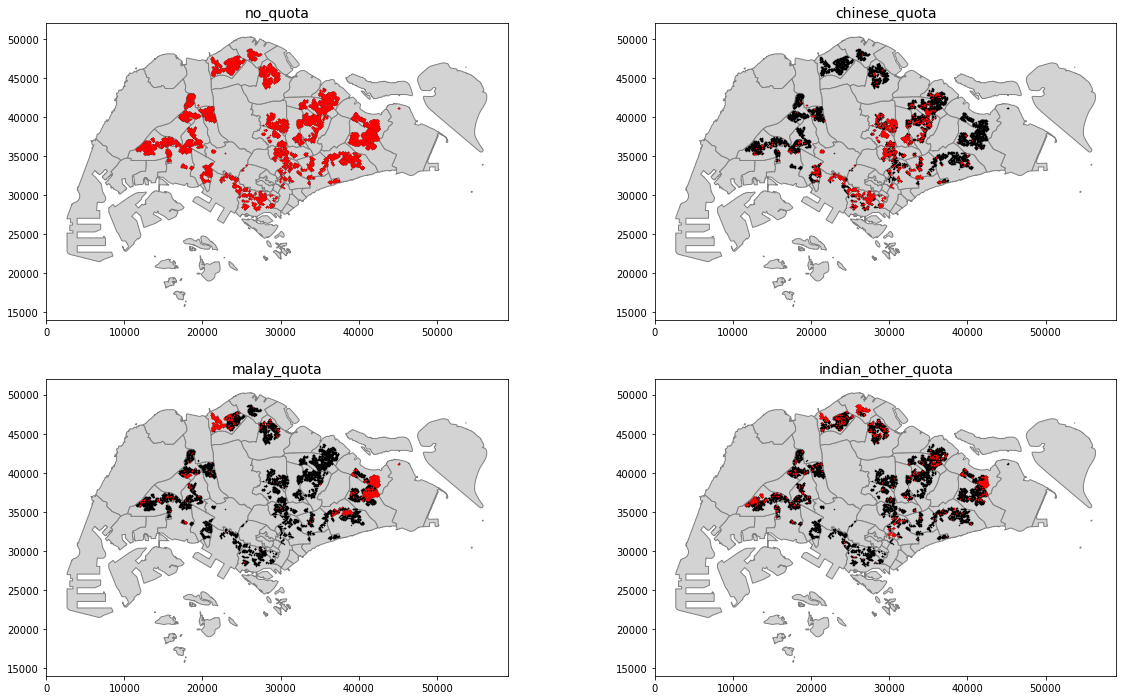

In [4]:
# geographical distribution of hdbs
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
ind = 0
quota_types = ["no_quota", "chinese_quota", "malay_quota", "indian_other_quota"]
for i in range(nrows): 
    for j in range(ncols):
        quota_type = quota_types[ind]
        filtered_geodf = hdb_geodf[hdb_geodf[quota_type] == 1]
        ax[i,j].set_title(quota_type, fontsize=14)
        planning_area_geodf.plot(ax=ax[i,j], color="lightgrey", edgecolor="grey")
        hdb_geodf.plot(ax=ax[i,j], color="black", markersize=0.25)
        filtered_geodf.plot(ax=ax[i,j], color="red", markersize=0.25)
        ind += 1

# save image
fig.savefig('images/data_plots/hdb_quota_map.jpg',bbox_inches='tight', dpi=150)

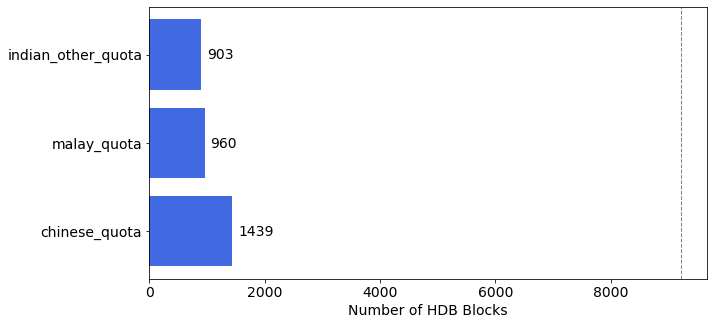

In [5]:
labels = ["chinese_quota", "malay_quota", "indian_other_quota"]
values = list(hdb_df[labels].sum(axis=0))

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.figure(figsize=(10,5))
plt.barh(labels, values, color="royalblue")
plt.axvline(x=len(hdb_df),linewidth=1, linestyle='--', color="gray")
plt.xlabel("Number of HDB Blocks", fontsize=14)

for i, v in enumerate(values):
    plt.text(v + 100, i - 0.05, str(v), color='black', fontsize=14)
    
plt.savefig('images/data_plots/hdb_quota_count.jpg',bbox_inches='tight', dpi=150)

# Restaurants

## Preprocess Restaurant Data

In [3]:
import ast

def process_csv_lists(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x))
    return df

In [4]:
restaurant_df = pd.read_csv("./data/restaurant_all.csv")
restaurant_df = process_csv_lists(df=restaurant_df, columns=["categories"])
# ["categories", "restaurant_operating_hours", "restaurant_photo"]
restaurant_df.head()

,id,name,term,location,lat,long,price_per_pax,categories
0,176803,Alstern Asian Cuisine,alstern-asian-cuisine,Kaki Bukit,1.337163,103.906854,NaN,"[Kopitiam, Korean BBQ, Hot Pot, Chinese, Korean]"
1,227596,Nasty Cookie Factory (Kaki Bukit),nasty-cookie-factory,Kaki Bukit,1.336559,103.909510,5.0,"[Desserts, Cafes & Coffee]"
2,27549,Eunos Techpark Kopitiam,eunos-techpark-level3,Kaki Bukit,1.334583,103.904875,5.0,"[Kopitiam, Hawker Food]"
3,11107,302 Food Paradise,302-food-paradise,Kaki Bukit,1.341580,103.912835,10.0,"[Hawker Food, Kopitiam]"
4,24681,FoodLoft (Kaki Bukit Avenue 1),food-loft-block,Kaki Bukit,1.332915,103.904277,10.0,"[Hawker Food, Kopitiam]"


In [5]:
categories = set()
for cats in restaurant_df.categories:
    for cat in cats:
        categories.add(cat)
print(categories)

{'', 'Indonesian', 'Mediterranean', 'Local Delights', 'European', 'Cafes & Coffee', 'Char Kway Teow', 'Chirashi', 'Buffets', 'Rainy Day Comforts', 'Teppanyaki', 'Noodles', 'Nasi Lemak', 'Fruit Tea', 'Russian', 'Healthy', 'Vegan', 'Soup', 'Takeaway Available', 'Michelin Guide Singapore 2017', 'Argentinian', 'Craft Beer', 'Hawker Food', 'Steak', 'Michelin Guide Singapore 2018', 'Good For Groups', 'Greek', 'Late Night', 'Mookata', 'Indian', 'Hot Pot', 'Zi Char', 'Chinese', 'Desserts', 'Kopitiam', 'Dinner with Drinks', 'Brazilian', 'Bak Kut Teh', 'Burpple Guides', 'Great View', 'Korean Desserts', 'Date Night', 'Ramen', 'Vietnamese', 'Pizza', 'Burgers', 'Dim Sum', 'Seafood', 'Waffles', 'Middle Eastern', 'Healthier Choice', '1-for-1 Takeaway', 'Cakes', 'Sandwiches', 'Vegetarian', 'Fine Dining', 'Chicken Rice', 'Supper', 'Western', 'Thai', '1-for-1 Deals', 'Korean Fried Chicken', 'Interesting', 'Breakfast & Brunch', 'Turkish', 'Korean', 'BBQ', 'Korean BBQ', 'Hidden Gem', 'Outdoor Dining', 'Ja

In [21]:
for cat in filtered_cats:
    restaurant_df[cat] = [1 if cat in x else 0 for x in restaurant_df["categories"]]
for cat in additional_cats:
    restaurant_df[cat] = 0
    
for prev_cat in CATEGORY_CUISINE_MAPPING.keys():
    for new_cat in CATEGORY_CUISINE_MAPPING[prev_cat]:
        updated_row = restaurant_df[new_cat]
        for i, row in restaurant_df.iterrows():
            if prev_cat in row["categories"]:
                updated_row[i] = 1
        restaurant_df[new_cat] = updated_row

restaurant_df = restaurant_df[["name", "term", "location", "lat", "long", "price_per_pax"] + filtered_cats + additional_cats]

<ipython-input-21-ef2fd73e89cc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_row[i] = 1


In [3]:
# process restaurant categories
def unpack_categories(category_string):
    x = category_string.split("'")
    return [x[i] for i in range(len(x)) if i % 2 == 1 and len(x[i]) > 0]

category_cuisine_mapping = {"Dim Sum": "Chinese", "Ramen": "Others", "Zi Char": "Chinese",
    "Pasta": "Western", "Korean Desserts": "Others", "Korean BBQ": "Others", "Korean Fried Chicken": "Others",
    "Mookata": "Others", "Teppanyaki": "Others", "Sushi": "Others", "Chirashi": "Others", "Chicken Rice": "Chinese",
    "Burgers": "Western", "Bak Kut Teh": "Chinese", "Char Kway Teow": "Chinese", "Steak": "Western",
    "Hot Pot": "Chinese", "Nasi Lemak": "Malay", "Pizza": "Western", "Argentinian": "Western", 
    "Brazilian": "Western",  "European": "Western", "Greek": "Western", "French": "Western",
    "Mediterranean": "Others", "Turkish": "Others", "Russian": "Western", "Taiwanese": "Chinese",
    "Indonesian": "Malay", "Spanish": "Mexican", "Salads": "Western", "Sandwiches": "Western", "Fast Food": "Western",
    "Cafes & Coffee": "Western", "Bubble Tea": "Chinese", "Breakfast & Brunch": "Western", "Bars": "Western",
    "Waffles": "Western", "Italian": "Western", "Middle Eastern": "Others", "Japanese": "Others",
    "Korean": "Others", "Thai": "Others", "Vietnamese": "Others", "Mexican": "Others", "Kopitiam": "Hawker Food",
    "Spanish": "Western", "Desserts": "Others", "Bread & Pastries": "Others", "Fruit Tea": "Chinese",
    "Halal": "Malay"
}

# read restaurant data
restaurant_df = pd.read_csv("./data/restaurant_all.csv")

# remove restaurants with no lat long information
restaurant_df = restaurant_df[restaurant_df["lat"] != 0][restaurant_df["long"] != 0] 

# sort restaurant categories into cuisines
restaurant_df["categories_list"] = restaurant_df["categories"].apply(unpack_categories)
cuisines = ["Chinese", "Malay", "Indian", "Western", "Others", "Peranakan", "Hawker Food"]
for cat in cuisines:
    restaurant_df[cat] = [1 if cat in x else 0 for x in restaurant_df["categories"]]
for cat in category_cuisine_mapping.keys():
    cuisine = category_cuisine_mapping[cat]
    updated_row = restaurant_df[cuisine]
    for i, row in restaurant_df.iterrows():
        if cat in row["categories"]:
            updated_row[i] = 1
    restaurant_df[cuisine] = updated_row

restaurant_df = restaurant_df[["name", "term", "location", "lat", "long", "price_per_pax"] + cuisines]

# retrieve svy21 coordinates of restaurants
cv = utils.SVY21()
restaurant_svy21 = [cv.computeSVY21(xy[0], xy[1]) for xy in zip(restaurant_df["lat"], restaurant_df["long"])]
restaurant_df["svy21_x"] = [x[1] for x in restaurant_svy21]
restaurant_df["svy21_y"] = [x[0] for x in restaurant_svy21]

# filter prices 
restaurant_df["price_per_pax"][restaurant_df["price_per_pax"] < 0] = 0

# save to csv
restaurant_df.to_csv("./data/restaurant_all_processed.csv", index=False)

<ipython-input-3-0db2bffdc6ac>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  restaurant_df = restaurant_df[restaurant_df["lat"] != 0][restaurant_df["long"] != 0]
<ipython-input-3-0db2bffdc6ac>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_row[i] = 1
<ipython-input-3-0db2bffdc6ac>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df["price_per_pax"][restaurant_df["price_per_pax"] < 0] = 0


## Visualise Restaurant Data

In [27]:
restaurant_df = pd.read_csv("./data/restaurant_all_processed.csv")
restaurant_aggregates = restaurant_df.agg({"price_per_pax": ["min", "max", "mean", "median", "skew"], 
                                           "Chinese": ["sum", "min", "max"],
                                           "Malay": ["sum", "min", "max"],
                                           "Indian": ["sum", "min", "max"],
                                           "Western": ["sum", "min", "max"],
                                           "Peranakan": ["sum", "min", "max"],
                                           "Hawker Food": ["sum", "min", "max"],
                                           "Others": ["sum", "min", "max"],
                                           })

restaurant_aggregates.to_latex('./images/data_plots/eateries_aggregate_data_orig.tex', 
                               float_format="%.2f", bold_rows=True,
                               caption="Summary Statistics of Restaurant Data")

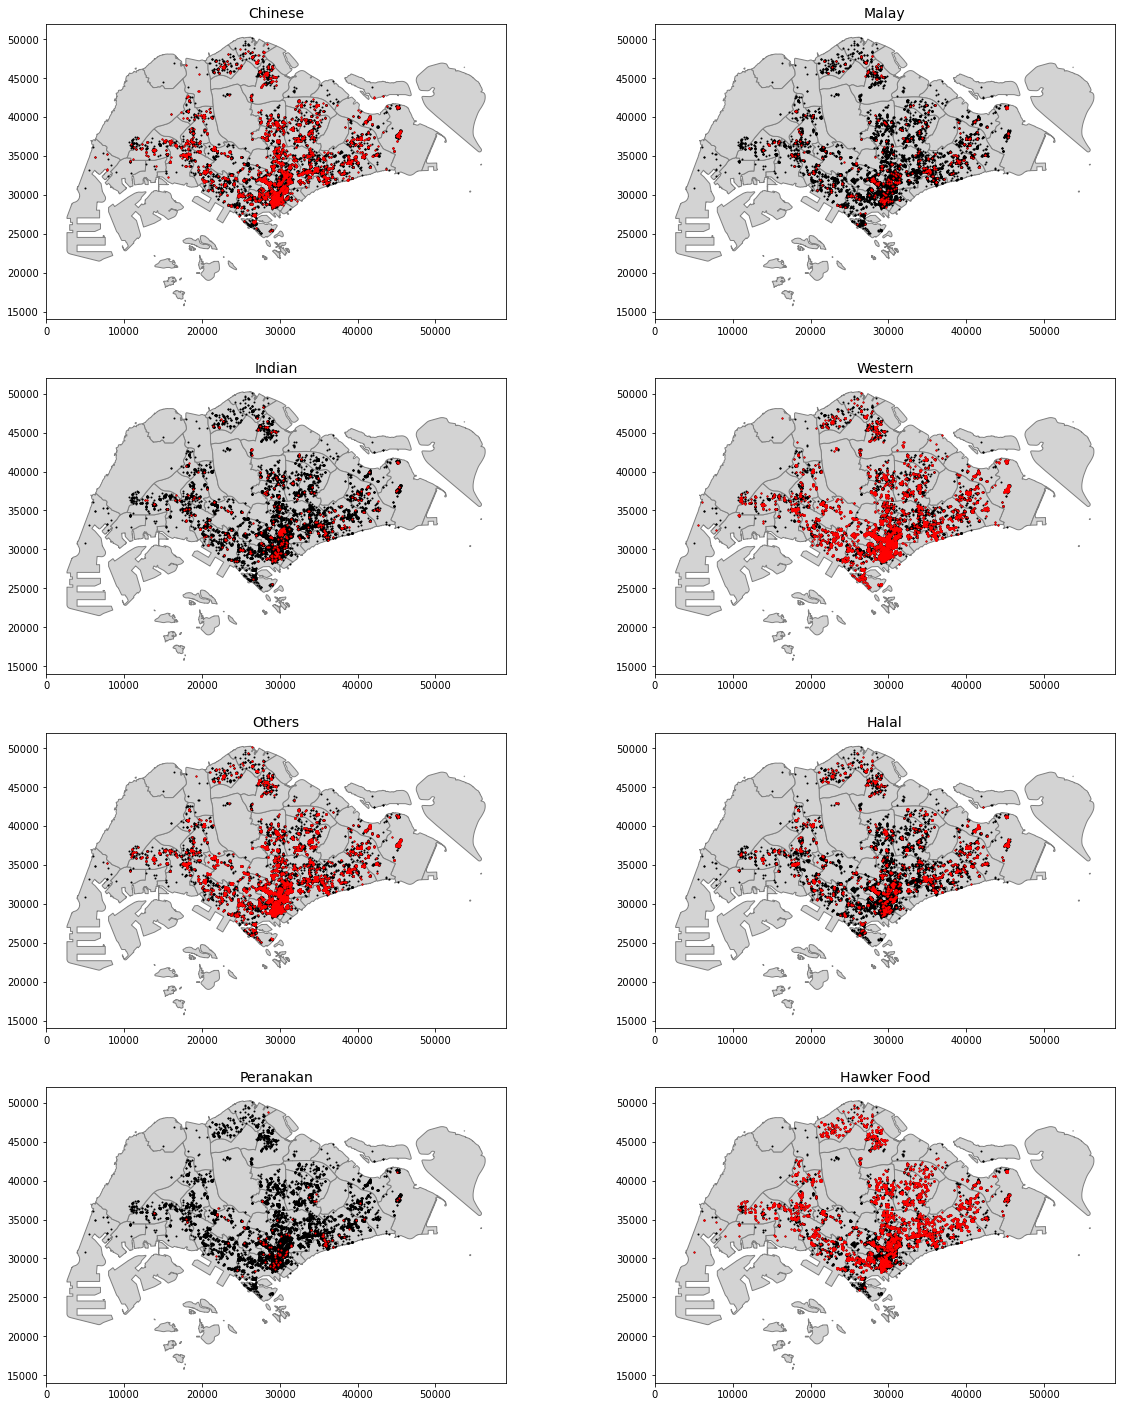

In [5]:
restaurant_df = pd.read_csv("./data/restaurant_all_processed.csv")

# create points
restaurant_geometry = [Point(xy) for xy in zip(restaurant_df["svy21_x"], restaurant_df["svy21_y"])]
restaurant_geodf = gpd.GeoDataFrame(restaurant_df, geometry=restaurant_geometry)

# split by cuisine and plot
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 25))
ind = 0
cuisines = ["Chinese", "Malay", "Indian", "Western", "Others", "Halal", "Peranakan", "Hawker Food"]
for i in range(nrows): 
    for j in range(ncols):
        cuisine = cuisines[ind]
        filtered_geodf = restaurant_geodf[restaurant_geodf[cuisine] == 1]
        ax[i,j].set_title(cuisine, fontsize=14)
        planning_area_geodf.plot(ax=ax[i,j], color="lightgrey", edgecolor="grey")
        restaurant_geodf.plot(ax=ax[i,j], color="black", markersize=1)
        filtered_geodf.plot(ax=ax[i,j], color="red", markersize=1)
        ind += 1
        
fig.savefig('images/data_plots/eateries_map.jpg',bbox_inches='tight', dpi=150)

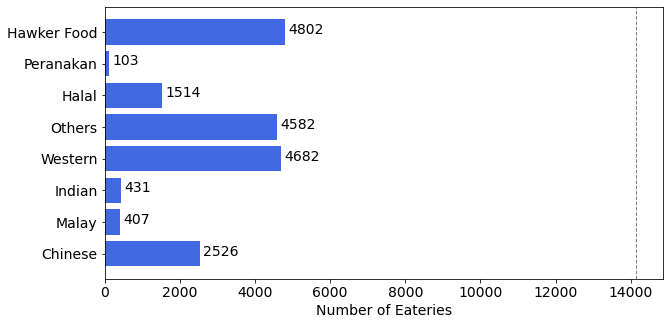

In [9]:
labels = cuisines
values = list(restaurant_df[labels].sum(axis=0))

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.figure(figsize=(10,5))
plt.barh(labels, values, color="royalblue")
plt.axvline(x=len(restaurant_df),linewidth=1, linestyle='--', color="gray")
plt.xlabel("Number of Eateries", fontsize=14)

for i, v in enumerate(values):
    plt.text(v + 100, i - 0.05, str(v), color='black', fontsize=14)
    
plt.savefig('images/data_plots/eateries_count.jpg',bbox_inches='tight', dpi=150)

# Combine Data

In [ ]:
hdb_df = pd.read_csv("./data/hdb_quotas_all.csv")
restaurant_df = pd.read_csv("./data/restaurant_all_processed.csv")

In [ ]:
def compute_quota_perc(hdb_df, distance, max_dist, min_dist=0):
    filtered_df = hdb_df[[x <= max_dist and x > min_dist for x in distance]]
    filtered_df_perc = filtered_df[["chinese_quota", "malay_quota", "indian_other_quota"]].mean(axis=0)
    return filtered_df_perc

In [ ]:
labels = ["chinese_quota", "malay_quota", "indian_other_quota"]

distance_segments = [0, 0.5, 1.0, 5.0]
distance_perc = {}
    
for i in range(1, len(distance_segments)):
    distance_perc["chinese_quota_" + str(distance_segments[i])] = []
    distance_perc["malay_quota_" + str(distance_segments[i])] = []
    distance_perc["indian_other_quota_" + str(distance_segments[i])] = []

for i, res in restaurant_df.iterrows():
    # compute distance of hdb from restaurant
    res_loc = (res["lat"], res["long"])
    distance = [haversine(res_loc, (x["latitude"], x["longitude"])) for ind, x in hdb_df.iterrows()]

    # compute percentage
    for i in range(1, len(distance_segments)):
        # compute percentage by distance
        max_dist = distance_segments[i]
        min_dist = distance_segments[i-1]
        hdb_perc = compute_quota_perc(hdb_df, distance, max_dist=max_dist, min_dist=min_dist)
        
        # add to dict
        distance_perc["chinese_quota_" + str(distance_segments[i])].append(hdb_perc["chinese_quota"])
        distance_perc["malay_quota_" + str(distance_segments[i])].append(hdb_perc["malay_quota"])
        distance_perc["indian_other_quota_" + str(distance_segments[i])].append(hdb_perc["indian_other_quota"])

restaurant_df_processed = restaurant_df.copy(deep=True)
for i in range(1, len(distance_segments)):
    chi_quota = "chinese_quota_" + str(distance_segments[i])
    restaurant_df_processed[chi_quota] = distance_perc[chi_quota]
    mal_quota = "malay_quota_" + str(distance_segments[i])
    restaurant_df_processed[mal_quota] = distance_perc[mal_quota]
    io_quota = "indian_other_quota_" + str(distance_segments[i])
    restaurant_df_processed[io_quota] = distance_perc[io_quota]
    
restaurant_df_processed.to_csv("./data/restaurant_hdb_combined.csv", index=False)